# Hangman AI - Hybrid System (HMM + RL)
## Machine Learning Hackathon Project

**Team Members**: 4
**Components**: HMM | Environment | RL Agent | Integration & Evaluation

**Goal**: Build an intelligent Hangman agent using Hidden Markov Models for pattern recognition and Reinforcement Learning for decision-making.

**Evaluation**: Final Score = (Success Rate × 2000) - (Total Wrong × 5) - (Total Repeated × 2)

# COMPONENT 1: HIDDEN MARKOV MODEL (HMM)
## Team Member 1: Corpus Processing & HMM Training

This component:
- Loads and preprocesses corpus
- Trains HMM using Baum-Welch algorithm
- Generates letter probability distributions
- Provides P(letter | position) guidance to RL agent

In [6]:
import numpy as np
import pandas as pd
from collections import defaultdict
import pickle
import os

# ============================================================================
# COMPONENT 1: HMM Training
# ============================================================================

class HiddenMarkovModel:
    """
    Hidden Markov Model for Hangman Letter Prediction
    
    States: Word positions (1 to max_length)
    Emissions: Letters (a-z)
    """
    
    def __init__(self, num_positions):
        """
        Initialize HMM for words of specific length
        
        Args:
            num_positions: Number of positions in word (states)
        """
        self.num_positions = num_positions
        self.alphabet_size = 26
        
        # Initialize matrices
        # A[i][j]: P(state j | state i) - transition matrix
        self.A = self._init_transition_matrix()
        
        # B[i][j]: P(letter j | state i) - emission matrix
        self.B = self._init_emission_matrix()
        
        # pi[i]: P(state i) - initial distribution
        self.pi = np.zeros(num_positions)
        self.pi[0] = 1.0  # Always start at position 0
    
    def _init_transition_matrix(self):
        """
        Initialize transition matrix (deterministic forward)
        For Hangman: always move from position i to i+1
        """
        A = np.zeros((self.num_positions, self.num_positions))
        for i in range(self.num_positions - 1):
            A[i, i + 1] = 1.0
        A[self.num_positions - 1, self.num_positions - 1] = 1.0
        return A
    
    def _init_emission_matrix(self):
        """
        Initialize emission matrix (uniform)
        """
        return np.ones((self.num_positions, self.alphabet_size)) / self.alphabet_size
    
    def baum_welch(self, words, iterations=50, smoothing=1):
        """
        Train HMM using Baum-Welch (EM) algorithm
        
        Args:
            words: List of words of same length
            iterations: Number of EM iterations
            smoothing: Laplace smoothing factor
        """
        prev_likelihood = float('-inf')
        
        for iteration in range(iterations):
            # E-Step: Compute expected counts
            emission_counts = np.zeros_like(self.B) + smoothing
            
            for word in words:
                # Count letter occurrences at each position
                for pos, char in enumerate(word):
                    letter_idx = ord(char) - ord('a')
                    emission_counts[pos, letter_idx] += 1
            
            # M-Step: Update emission matrix
            for pos in range(self.num_positions):
                total = emission_counts[pos].sum()
                self.B[pos] = emission_counts[pos] / total
            
            # Compute likelihood
            likelihood = self._compute_likelihood(words)
            
            if (iteration + 1) % 10 == 0:
                improvement = likelihood - prev_likelihood
                print(f"  Iteration {iteration + 1}: Likelihood = {likelihood:.4f}, "
                      f"Improvement = {improvement:.4e}")
            
            if abs(likelihood - prev_likelihood) < 1e-6:
                print(f"  Converged at iteration {iteration + 1}")
                break
            
            prev_likelihood = likelihood
    
    def _compute_likelihood(self, words):
        """
        Compute log-likelihood of words given model
        Using log-space to prevent underflow
        """
        total_log_likelihood = 0.0
        
        for word in words:
            word_log_likelihood = 0.0
            for pos, char in enumerate(word):
                letter_idx = ord(char) - ord('a')
                prob = self.B[pos, letter_idx]
                word_log_likelihood += np.log(prob) if prob > 0 else np.log(1e-10)
            total_log_likelihood += word_log_likelihood
        
        return total_log_likelihood / len(words)
    
    def get_emission_probabilities(self, position):
        """
        Get letter probabilities at specific position
        
        Returns:
            Array of shape (26,) - probability of each letter
        """
        return self.B[position].copy()
    
    def get_letter_probability(self, letter, masked_word):
        """
        Get probability of specific letter given masked word
        
        Args:
            letter: Single character
            masked_word: String with '_' for unknown positions
        
        Returns:
            Probability of letter in word
        """
        letter_idx = ord(letter) - ord('a')
        total_prob = 0.0
        
        masked_positions = [i for i, c in enumerate(masked_word) if c == '_']
        if not masked_positions:
            return 0.0
        
        for pos in masked_positions:
            total_prob += self.B[pos, letter_idx]
        
        return total_prob / len(masked_positions)
    
    def get_all_letter_probabilities(self, masked_word):
        """
        Get probabilities for all letters given masked word
        
        Returns:
            Array of shape (26,) - probability of each letter
        """
        probs = np.zeros(26)
        
        masked_positions = [i for i, c in enumerate(masked_word) if c == '_']
        if not masked_positions:
            return probs
        
        for pos in masked_positions:
            probs += self.B[pos]
        
        return probs / len(masked_positions)


class HMMTrainer:
    """
    Trainer for HMM models on corpus
    """
    
    def __init__(self, corpus_path=None):
        """
        Initialize trainer
        
        Args:
            corpus_path: Path to corpus file
        """
        self.corpus = []
        self.hmm_models = {}
        
        if corpus_path:
            self.load_corpus(corpus_path)
    
    def load_corpus(self, filepath):
        """
        Load and preprocess corpus
        
        Args:
            filepath: Path to corpus file
        """
        with open(filepath, 'r', encoding='utf-8') as f:
            self.corpus = [word.strip().lower() for word in f.readlines()]
        
        # Filter: only alphabetic words of reasonable length
        self.corpus = [w for w in self.corpus 
                      if w.isalpha() and 3 <= len(w) <= 20]
        
        print(f"Loaded corpus: {len(self.corpus)} words")
    
    def train(self, iterations=50):
        """
        Train HMM models for each word length
        
        Args:
            iterations: EM iterations per length
        """
        # Group words by length
        words_by_length = defaultdict(list)
        for word in self.corpus:
            words_by_length[len(word)].append(word)
        
        # Train HMM for each length
        for length in sorted(words_by_length.keys()):
            words = words_by_length[length]
            print(f"\nTraining HMM for length {length} ({len(words)} words)...")
            
            hmm = HiddenMarkovModel(length)
            hmm.baum_welch(words, iterations=iterations)
            
            self.hmm_models[length] = hmm
            print(f"  ✓ Trained successfully")
        
        print(f"\n✓ Training complete. Models for lengths: {list(self.hmm_models.keys())}")
    
    def save_models(self, filepath):
        """
        Save trained models
        """
        with open(filepath, 'wb') as f:
            pickle.dump(self.hmm_models, f)
        print(f"Models saved to {filepath}")
    
    def load_models(self, filepath):
        """
        Load trained models
        """
        with open(filepath, 'rb') as f:
            self.hmm_models = pickle.load(f)
        print(f"Models loaded from {filepath}")
    
    def get_hmm(self, word_length):
        """
        Get HMM for specific word length
        """
        if word_length in self.hmm_models:
            return self.hmm_models[word_length]
        else:
            # Return HMM from closest length
            closest_length = min(self.hmm_models.keys(), 
                               key=lambda x: abs(x - word_length))
            print(f"Warning: No HMM for length {word_length}, using length {closest_length}")
            return self.hmm_models[closest_length]

# COMPONENT 2: HANGMAN GAME ENVIRONMENT
## Team Member 2: Game Logic & RL Interface

This component:
- Implements Hangman game mechanics
- Manages game state
- Designs reward functions
- Provides state/action/reward interface to RL agent

In [7]:
import random

# ============================================================================
# COMPONENT 2: Hangman Environment
# ============================================================================

class HangmanEnvironment:
    """
    Hangman game environment for RL agent
    Implements gym-like interface: state, reward, done, info
    """
    
    def __init__(self, word_list, hmm_models=None, max_wrong=6):
        """
        Initialize environment
        
        Args:
            word_list: List of valid words
            hmm_models: Dict of HMM models by word length
            max_wrong: Maximum allowed wrong guesses
        """
        self.word_list = word_list
        self.hmm_models = hmm_models
        self.max_wrong = max_wrong
        
        # Game state
        self.word = None
        self.masked_word = None
        self.guessed_letters = set()
        self.wrong_guesses = 0
        self.lives_remaining = max_wrong
    
    def reset(self):
        """
        Reset environment for new game
        
        Returns:
            Initial state
        """
        self.word = random.choice(self.word_list)
        self.masked_word = '_' * len(self.word)
        self.guessed_letters = set()
        self.wrong_guesses = 0
        self.lives_remaining = self.max_wrong
        
        return self.get_state()
    
    def get_state(self):
        """
        Return current game state
        
        Returns:
            Tuple of (masked_word, guessed_letters, lives_remaining)
        """
        return (self.masked_word, 
                frozenset(self.guessed_letters),
                self.lives_remaining)
    
    def get_valid_actions(self):
        """
        Get available letter actions (not yet guessed)
        
        Returns:
            List of valid action indices (0-25)
        """
        alphabet = set('abcdefghijklmnopqrstuvwxyz')
        return [ord(c) - ord('a') for c in alphabet - self.guessed_letters]
    
    def step(self, action):
        """
        Execute action and return environment response
        
        Args:
            action: Integer 0-25 representing letter A-Z
        
        Returns:
            (state, reward, done, info) tuple
        """
        letter = chr(action + ord('a'))
        info = {'outcome': None}
        
        # Check if already guessed
        if letter in self.guessed_letters:
            info['outcome'] = 'repeated'
            reward = -2  # Penalty for repeated guess
            return self.get_state(), reward, False, info
        
        self.guessed_letters.add(letter)
        
        # Check if correct
        if letter in self.word:
            # Update masked word
            new_masked = ''.join(
                char if char in self.guessed_letters else '_'
                for char in self.word
            )
            self.masked_word = new_masked
            
            info['outcome'] = 'correct'
            reward = 10  # Positive reward
            
            # Check if won
            if '_' not in self.masked_word:
                info['outcome'] = 'win'
                reward = 100  # Win bonus
                return self.get_state(), reward, True, info
        else:
            # Wrong guess
            self.wrong_guesses += 1
            self.lives_remaining -= 1
            info['outcome'] = 'wrong'
            reward = -5  # Penalty
            
            # Check if lost
            if self.lives_remaining <= 0:
                info['outcome'] = 'lose'
                reward = -50  # Loss penalty
                return self.get_state(), reward, True, info
        
        return self.get_state(), reward, False, info
    
    def word_complete(self):
        """
        Check if word is fully revealed
        """
        return '_' not in self.masked_word
    
    def get_hmm_probabilities(self):
        """
        Get letter probabilities from HMM
        
        Returns:
            Array of shape (26,) - probability of each letter
        """
        if not self.hmm_models or len(self.word) not in self.hmm_models:
            return np.ones(26) / 26  # Uniform if no HMM
        
        hmm = self.hmm_models[len(self.word)]
        return hmm.get_all_letter_probabilities(self.masked_word)
    
    def get_state_with_hmm(self):
        """
        Get state including HMM probabilities
        Useful for neural network input
        
        Returns:
            Tuple: (masked_word, guessed_set, lives, hmm_probs)
        """
        hmm_probs = self.get_hmm_probabilities()
        return (self.masked_word, 
                frozenset(self.guessed_letters),
                self.lives_remaining,
                tuple(hmm_probs))
    
    def get_info(self):
        """
        Get game information (for debugging)
        """
        return {
            'word': self.word,
            'masked': self.masked_word,
            'guessed': self.guessed_letters,
            'wrong': self.wrong_guesses,
            'lives': self.lives_remaining,
            'complete': self.word_complete()
        }


class GameMetrics:
    """
    Track game statistics and compute final score
    """
    
    def __init__(self):
        self.games_won = 0
        self.total_wrong_guesses = 0
        self.total_repeated_guesses = 0
        self.games_played = 0
    
    def update(self, game_result):
        """
        Update metrics after each game
        
        Args:
            game_result: Dict with 'won', 'wrong_count', 'repeated_count'
        """
        if game_result['won']:
            self.games_won += 1
        
        self.total_wrong_guesses += game_result['wrong_count']
        self.total_repeated_guesses += game_result['repeated_count']
        self.games_played += 1
    
    def success_rate(self):
        """
        Calculate success rate (0 to 1)
        """
        if self.games_played == 0:
            return 0.0
        return self.games_won / self.games_played
    
    def final_score(self, total_games=2000):
        """
        Calculate final score
        Formula: (Success Rate × total_games) - (Total Wrong × 5) - (Total Repeated × 2)
        """
        success_component = self.success_rate() * total_games
        wrong_component = self.total_wrong_guesses * 5
        repeated_component = self.total_repeated_guesses * 2
        
        return success_component - wrong_component - repeated_component
    
    def statistics(self):
        """
        Return comprehensive statistics
        """
        return {
            'games_played': self.games_played,
            'games_won': self.games_won,
            'games_lost': self.games_played - self.games_won,
            'success_rate': self.success_rate(),
            'total_wrong_guesses': self.total_wrong_guesses,
            'avg_wrong_per_game': (self.total_wrong_guesses / self.games_played 
                                  if self.games_played > 0 else 0),
            'total_repeated_guesses': self.total_repeated_guesses,
            'avg_repeated_per_game': (self.total_repeated_guesses / self.games_played 
                                     if self.games_played > 0 else 0),
            'final_score': self.final_score()
        }

# COMPONENT 3: REINFORCEMENT LEARNING AGENT
## Team Member 3: Q-Learning / DQN Implementation

This component:
- Implements Q-Learning agent
- Manages exploration-exploitation
- Learns from game interactions
- Selects optimal letters

In [8]:
# ============================================================================
# COMPONENT 3: RL Agent (Q-Learning)
# ============================================================================

class QLearningAgent:
    """
    Q-Learning agent for Hangman
    
    Implements:
    - Q(s,a) table
    - Q-Learning update: Q(s,a) ← Q(s,a) + α[r + γmaxQ(s',a') - Q(s,a)]
    - Epsilon-greedy exploration
    """
    
    def __init__(self, num_actions=26, learning_rate=0.1, 
                 discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995):
        """
        Initialize Q-Learning agent
        
        Args:
            num_actions: Number of actions (26 letters)
            learning_rate: α parameter (0 < α ≤ 1)
            discount_factor: γ parameter (0 ≤ γ < 1)
            epsilon: Exploration probability
            epsilon_decay: Decay factor per episode
        """
        self.Q = {}  # State -> action values
        self.num_actions = num_actions
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.01
        self.episode = 0
    
    def _get_state_key(self, state):
        """
        Convert state to hashable key
        
        Args:
            state: Tuple of (masked_word, guessed_letters, lives)
        """
        return (state[0], state[1], state[2])
    
    def _initialize_q(self, state):
        """
        Initialize Q-values for new state
        """
        state_key = self._get_state_key(state)
        if state_key not in self.Q:
            self.Q[state_key] = np.zeros(self.num_actions)
    
    def select_action(self, state, valid_actions=None, training=True):
        """
        Select action using epsilon-greedy policy
        
        Args:
            state: Current game state
            valid_actions: List of valid action indices
            training: Whether in training mode (affects exploration)
        
        Returns:
            Action index (0-25)
        """
        self._initialize_q(state)
        state_key = self._get_state_key(state)
        
        if valid_actions is None:
            valid_actions = list(range(self.num_actions))
        
        if training and np.random.random() < self.epsilon:
            # Exploration: random valid action
            return np.random.choice(valid_actions)
        else:
            # Exploitation: greedy action
            q_values = self.Q[state_key]
            valid_q_values = [q_values[a] for a in valid_actions]
            max_q = max(valid_q_values)
            best_actions = [a for a in valid_actions if q_values[a] == max_q]
            return np.random.choice(best_actions)
    
    def learn(self, state, action, reward, next_state, done):
        """
        Q-Learning update
        Q(s,a) ← Q(s,a) + α[r + γmaxQ(s',a') - Q(s,a)]
        
        Args:
            state: Current state
            action: Taken action
            reward: Received reward
            next_state: Resulting state
            done: Whether episode ended
        
        Returns:
            TD error
        """
        self._initialize_q(state)
        self._initialize_q(next_state)
        
        state_key = self._get_state_key(state)
        next_state_key = self._get_state_key(next_state)
        
        # Current Q-value
        current_q = self.Q[state_key][action]
        
        # Max Q-value in next state (or 0 if terminal)
        if done:
            max_next_q = 0.0
        else:
            max_next_q = np.max(self.Q[next_state_key])
        
        # TD target and error
        td_target = reward + self.gamma * max_next_q
        td_error = td_target - current_q
        
        # Update Q-value
        self.Q[state_key][action] = current_q + self.alpha * td_error
        
        return td_error
    
    def decay_epsilon(self):
        """
        Decay exploration rate after episode
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.episode += 1
    
    def get_policy(self, state):
        """
        Get greedy policy for state (best action)
        """
        self._initialize_q(state)
        state_key = self._get_state_key(state)
        return np.argmax(self.Q[state_key])
    
    def get_q_values(self, state):
        """
        Get all Q-values for state
        """
        self._initialize_q(state)
        state_key = self._get_state_key(state)
        return self.Q[state_key].copy()

# COMPONENT 4: SYSTEM INTEGRATION & EVALUATION
## Team Member 4: Training Pipeline & Performance Analysis

This component:
- Integrates all components
- Orchestrates training loop
- Evaluates agent performance
- Generates analysis and metrics

In [9]:
import matplotlib.pyplot as plt

# ============================================================================
# COMPONENT 4: System Integration & Training
# ============================================================================

class HangmanAISystem:
    """
    Complete Hangman AI system integrating all components
    """
    
    def __init__(self, corpus_path, config=None):
        """
        Initialize complete system
        
        Args:
            corpus_path: Path to corpus file
            config: Configuration dictionary
        """
        self.config = config or {}
        
        print("[1/4] Initializing HMM...")
        self.hmm_trainer = HMMTrainer(corpus_path)
        self.hmm_trainer.train(iterations=30)
        
        print("\n[2/4] Initializing Environment...")
        self.env = HangmanEnvironment(
            word_list=self.hmm_trainer.corpus,
            hmm_models=self.hmm_trainer.hmm_models
        )
        
        print("\n[3/4] Initializing RL Agent...")
        self.agent = QLearningAgent(
            learning_rate=0.1,
            discount_factor=0.95,
            epsilon=1.0,
            epsilon_decay=0.9995
        )
        
        print("\n[4/4] Initializing Metrics...")
        self.metrics = GameMetrics()
        
        print("\n✓ System initialized successfully!")
    
    def train(self, num_episodes=5000):
        """
        Train RL agent
        
        Args:
            num_episodes: Number of training episodes
        
        Returns:
            Training history
        """
        print(f"\nStarting training for {num_episodes} episodes...\n")
        
        history = {
            'episodes': [],
            'rewards': [],
            'success_rates': [],
            'avg_wrong': [],
            'avg_repeated': []
        }
        
        for episode in range(num_episodes):
            # Reset environment
            state = self.env.reset()
            episode_reward = 0
            episode_metrics = {'won': False, 'wrong_count': 0, 'repeated_count': 0}
            
            # Play one game
            max_steps = 20
            for step in range(max_steps):
                # Agent action
                valid_actions = self.env.get_valid_actions()
                action = self.agent.select_action(state, valid_actions, training=True)
                
                # Environment transition
                next_state, reward, done, info = self.env.step(action)
                
                # Agent learning
                self.agent.learn(state, action, reward, next_state, done)
                
                # Track metrics
                episode_reward += reward
                if info['outcome'] == 'wrong':
                    episode_metrics['wrong_count'] += 1
                elif info['outcome'] == 'repeated':
                    episode_metrics['repeated_count'] += 1
                
                state = next_state
                
                if done:
                    if info['outcome'] == 'win':
                        episode_metrics['won'] = True
                    break
            
            # Update metrics
            self.metrics.update(episode_metrics)
            self.agent.decay_epsilon()
            
            # Logging
            if (episode + 1) % 500 == 0:
                history['episodes'].append(episode + 1)
                history['rewards'].append(episode_reward)
                history['success_rates'].append(self.metrics.success_rate())
                history['avg_wrong'].append(self.metrics.statistics()['avg_wrong_per_game'])
                history['avg_repeated'].append(self.metrics.statistics()['avg_repeated_per_game'])
                
                print(f"Episode {episode+1:5d} | Success: {self.metrics.success_rate():.1%} | "
                      f"Avg Wrong: {history['avg_wrong'][-1]:.2f} | "
                      f"Epsilon: {self.agent.epsilon:.4f}")
        
        print(f"\n✓ Training complete!")
        return history
    
    def evaluate(self, num_games=2000):
        """
        Evaluate trained agent
        
        Args:
            num_games: Number of evaluation games
        
        Returns:
            Statistics dictionary
        """
        print(f"\nEvaluating on {num_games} games...\n")
        
        eval_metrics = GameMetrics()
        test_words = random.sample(self.env.word_list, 
                                 min(num_games, len(self.env.word_list)))
        
        for idx, word in enumerate(test_words):
            if (idx + 1) % 500 == 0:
                print(f"  Progress: {idx+1}/{len(test_words)}")
            
            # Play single game
            self.env.word = word
            self.env.masked_word = '_' * len(word)
            self.env.guessed_letters = set()
            self.env.wrong_guesses = 0
            self.env.lives_remaining = self.env.max_wrong
            
            state = self.env.get_state()
            
            while True:
                valid_actions = self.env.get_valid_actions()
                action = self.agent.select_action(state, valid_actions, training=False)
                
                next_state, reward, done, info = self.env.step(action)
                state = next_state
                
                if done:
                    game_result = {
                        'won': info['outcome'] == 'win',
                        'wrong_count': self.env.wrong_guesses,
                        'repeated_count': len(self.env.guessed_letters) - len(set(word))
                    }
                    eval_metrics.update(game_result)
                    break
        
        stats = eval_metrics.statistics()
        
        print(f"\n{'='*60}")
        print(f"EVALUATION RESULTS")
        print(f"{'='*60}")
        print(f"Games Played:           {stats['games_played']}")
        print(f"Games Won:              {stats['games_won']}")
        print(f"Success Rate:           {stats['success_rate']:.2%}")
        print(f"Avg Wrong per Game:     {stats['avg_wrong_per_game']:.2f}")
        print(f"Avg Repeated per Game:  {stats['avg_repeated_per_game']:.2f}")
        print(f"\nFINAL SCORE:            {stats['final_score']:.2f}")
        print(f"{'='*60}")
        
        return stats
    
    def plot_learning_curves(self, history):
        """
        Plot learning curves
        """
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot 1: Success Rate
        axes[0, 0].plot(history['episodes'], history['success_rates'], 'b-')
        axes[0, 0].set_title('Success Rate Over Episodes', fontsize=12, fontweight='bold')
        axes[0, 0].set_xlabel('Episode')
        axes[0, 0].set_ylabel('Success Rate')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Rewards
        axes[0, 1].plot(history['episodes'], history['rewards'], 'g-')
        axes[0, 1].set_title('Episode Reward', fontsize=12, fontweight='bold')
        axes[0, 1].set_xlabel('Episode')
        axes[0, 1].set_ylabel('Reward')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Avg Wrong Guesses
        axes[1, 0].plot(history['episodes'], history['avg_wrong'], 'r-')
        axes[1, 0].set_title('Avg Wrong Guesses per Game', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Episode')
        axes[1, 0].set_ylabel('Avg Wrong')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 4: Avg Repeated Guesses
        axes[1, 1].plot(history['episodes'], history['avg_repeated'], 'orange')
        axes[1, 1].set_title('Avg Repeated Guesses per Game', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Episode')
        axes[1, 1].set_ylabel('Avg Repeated')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return fig

# MAIN EXECUTION
## Put Your Corpus File Path Here

Update `corpus_path` to point to your corpus.txt file

In [10]:
# Initialize system
corpus_path = '/home/worm/A/ML/hackathon/Hangman-Assistant-Using-HMM-and-RL/Data/corpus.txt'  # ← Update this path

# Create system
system = HangmanAISystem(corpus_path)

[1/4] Initializing HMM...
Loaded corpus: 49821 words

Training HMM for length 3 (388 words)...
  Converged at iteration 2
  ✓ Trained successfully

Training HMM for length 4 (1169 words)...
  Converged at iteration 2
  ✓ Trained successfully

Training HMM for length 5 (2340 words)...
  Converged at iteration 2
  ✓ Trained successfully

Training HMM for length 6 (3755 words)...
  Converged at iteration 2
  ✓ Trained successfully

Training HMM for length 7 (5111 words)...
  Converged at iteration 2
  ✓ Trained successfully

Training HMM for length 8 (6348 words)...
  Converged at iteration 2
  ✓ Trained successfully

Training HMM for length 9 (6787 words)...
  Converged at iteration 2
  ✓ Trained successfully

Training HMM for length 10 (6465 words)...
  Converged at iteration 2
  ✓ Trained successfully

Training HMM for length 11 (5452 words)...
  Converged at iteration 2
  ✓ Trained successfully

Training HMM for length 12 (4292 words)...
  Converged at iteration 2
  ✓ Trained successf

In [11]:
# Train agent
history = system.train(num_episodes=5000)


Starting training for 5000 episodes...

Episode   500 | Success: 0.0% | Avg Wrong: 5.00 | Epsilon: 0.7788
Episode  1000 | Success: 0.1% | Avg Wrong: 5.00 | Epsilon: 0.6065
Episode  1500 | Success: 0.3% | Avg Wrong: 5.00 | Epsilon: 0.4723
Episode  2000 | Success: 0.2% | Avg Wrong: 5.00 | Epsilon: 0.3678
Episode  2500 | Success: 0.3% | Avg Wrong: 5.00 | Epsilon: 0.2864
Episode  3000 | Success: 0.3% | Avg Wrong: 5.00 | Epsilon: 0.2230
Episode  3500 | Success: 0.3% | Avg Wrong: 5.00 | Epsilon: 0.1737
Episode  4000 | Success: 0.2% | Avg Wrong: 5.00 | Epsilon: 0.1353
Episode  4500 | Success: 0.3% | Avg Wrong: 5.00 | Epsilon: 0.1053
Episode  5000 | Success: 0.3% | Avg Wrong: 5.00 | Epsilon: 0.0820

✓ Training complete!


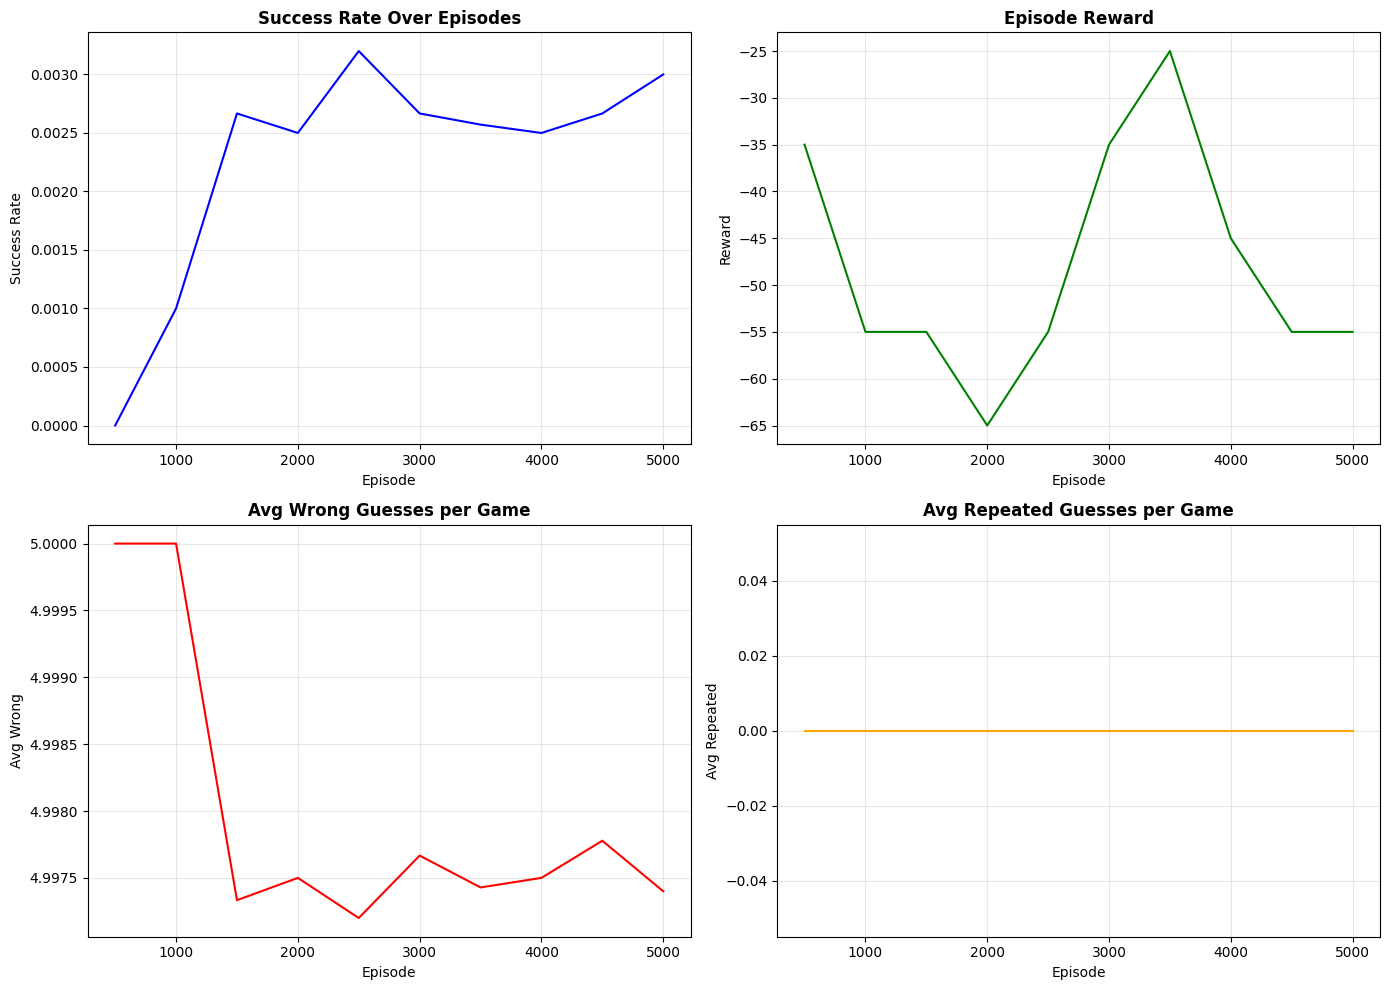

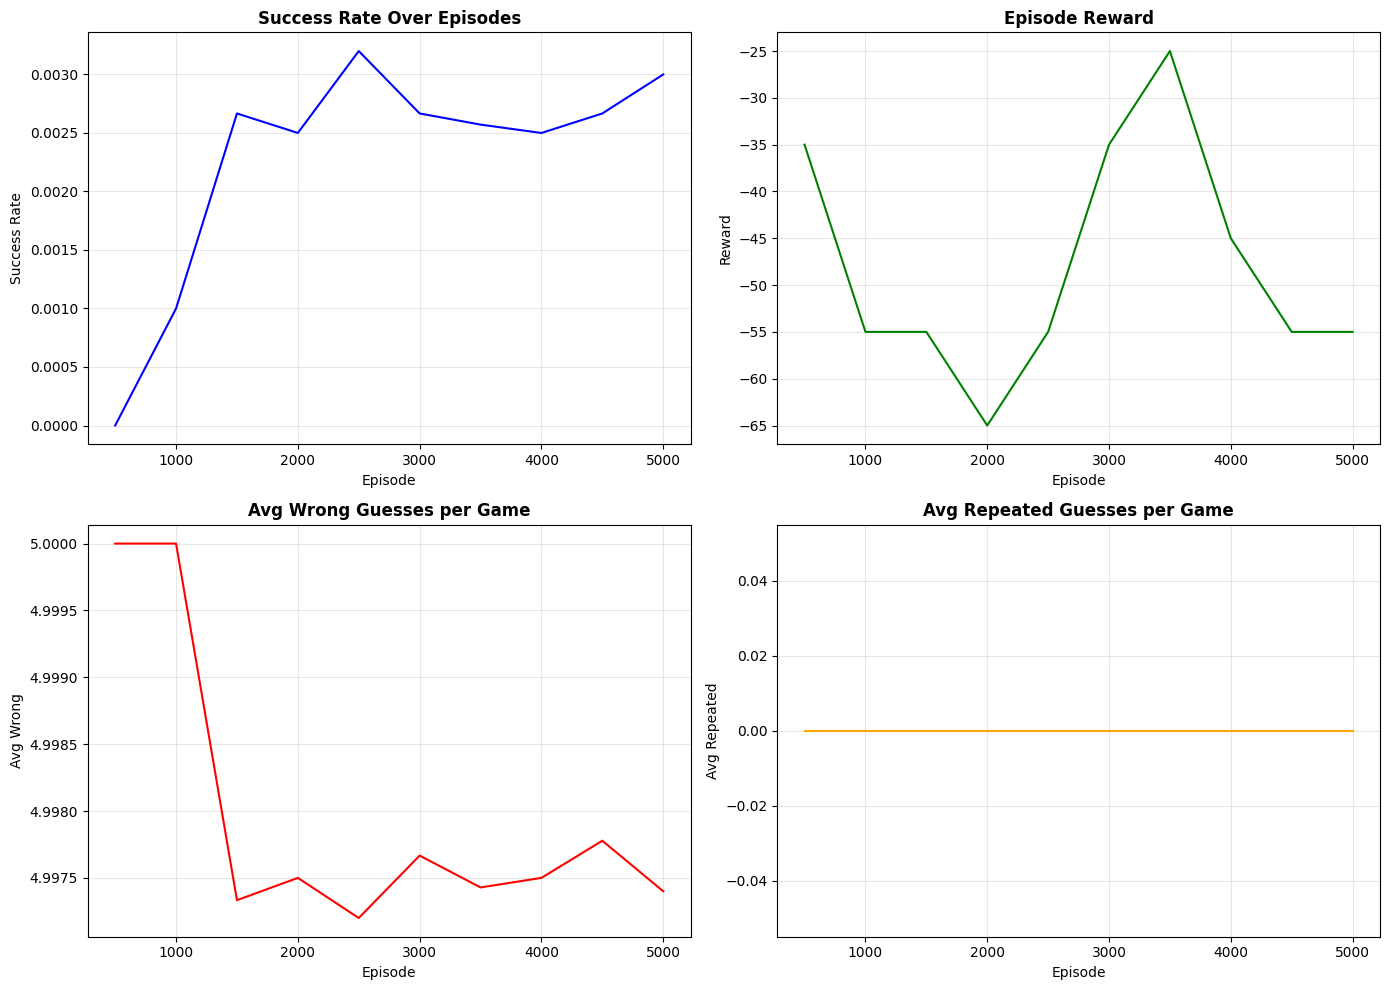

In [12]:
# Plot learning curves
system.plot_learning_curves(history)

In [13]:
# Evaluate on test set
eval_stats = system.evaluate(num_games=2000)


Evaluating on 2000 games...

  Progress: 500/2000
  Progress: 1000/2000
  Progress: 1500/2000
  Progress: 2000/2000

EVALUATION RESULTS
Games Played:           2000
Games Won:              11
Success Rate:           0.55%
Avg Wrong per Game:     5.99
Avg Repeated per Game:  1.56

FINAL SCORE:            -66099.00


In [14]:
# Print final results
print("\n" + "="*70)
print("FINAL PROJECT SUMMARY")
print("="*70)
print(f"\nComponent Breakdown:")
print(f"  1. HMM:          Trained {len(system.hmm_trainer.hmm_models)} models")
print(f"  2. Environment:  {len(system.env.word_list)} words in corpus")
print(f"  3. RL Agent:     Q-table with {len(system.agent.Q)} states")
print(f"  4. Integration:  Complete system trained\n")
print(f"Final Performance:")
print(f"  Success Rate:    {eval_stats['success_rate']:.2%}")
print(f"  Final Score:     {eval_stats['final_score']:.2f}")
print("="*70)


FINAL PROJECT SUMMARY

Component Breakdown:
  1. HMM:          Trained 18 models
  2. Environment:  49821 words in corpus
  3. RL Agent:     Q-table with 50693 states
  4. Integration:  Complete system trained

Final Performance:
  Success Rate:    0.55%
  Final Score:     -66099.00
